# Lab | Final regression model in "Health Care for All" Case

Instructions  
At this point, we have created a model to predict who will make a donation and who won't. But, what about the ammount of money that each person will give? In this lab, subset those that made a donation and use that subset to create a model to predict how much money will they give.

Evaluate the result of your model and estimate how much better the result are for the business in comparison with the naive scenario we discuss on Monday.

## Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', None)

#train-test-split
from sklearn.model_selection import train_test_split

#categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#for regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

#scaling numerical variables
from sklearn.preprocessing import MinMaxScaler

#for upsampling
from sklearn.utils import resample

#for pickling
import pickle

#for KBest Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

## Importing Models (pickle)

In [8]:
#clf (RandomForestClassifier)
clf = pickle.load(open('clf.p', 'rb'))

## Functions: 
- to check for null values in all the columns
- to check the data types
- to check collinearity

In [9]:
#Function to check for NaNs:
def get_percentnan(dataframe):
    data_percentnan = pd.DataFrame((dataframe.isna().sum()/len(dataframe))*100)
    data_percentnan = data_percentnan.reset_index()
    data_percentnan.columns = ['column_name', 'nulls_percentage']
    data_percentnan = data_percentnan[(data_percentnan['nulls_percentage'] > 0)]
    
    return data_percentnan

In [10]:
#check the columns and the data types
def data_colandtype(dataframe):
    data_col = pd.DataFrame(dataframe.iloc[0 , :])
    data_col['type'] = dataframe.dtypes
    unique_values = []
    for column in dataframe.columns:
        unique_values.append(len(dataframe[column].unique()))
    data_col['#_unique_values'] = unique_values
    data_col = data_col.reset_index()
    data_col.columns = ['header_name', 'row_0', 'type','#_unique_values']
    pd.set_option('display.max_rows', None)
    display(data_col)
    return


In [11]:
#Check collinearity
def getcollinearity(corr_matrix, column_to_check):
    collinearity = corr_matrix[(corr_matrix[column_to_check] >= abs(0.5))]
    collinearity = collinearity[column_to_check]
    return collinearity

## Get data and have a look

In [12]:
numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
target = pd.read_csv('target.csv')

In [13]:
display(numerical.shape)
numerical.head()

(95412, 315)

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3,3,0,497,546,2,1,78,22,93,7,18,36,76,65,30,86,14,7,2,5,11,17,3,17,60,18,0,1,0,0,1,6,18,50,0,4,36,49,51,14,5,4,2,24,11,2,3,6,0,2,9,44,0.0,281.0,518.0,251,292,292,340,11576,32,18,20,15,12,2,0,0,1,20,19,24,18,16,2,0,0,1,28,8,31,11,38,62,8,74,22,0,0,0,0,0,2,2,1,21,19,24,6,61,65,73,59,70,56,78,62,82,99,4,10,5,2,6,12,0,1,9,5,18,20,5,7,6,0,11,33,4,3,2,12,3,3

In [14]:
display(categorical.shape)
categorical.head()

(95412, 22)

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1
3,CA,44,U,F,3,L,E,C,R,2,87,1,28,1,87,11,94,11,95,12,87,2
4,FL,16,H,F,3,L,F,A,S,2,86,1,20,1,93,10,96,1,96,1,79,3


In [15]:
display(target.shape)
display(target.head())
data_colandtype(target)

(95412, 2)

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


,header_name,row_0,type,#_unique_values
0,TARGET_B,0.0,int64,2
1,TARGET_D,0.0,float64,71


In [16]:
#concatenate the data
data = pd.concat([numerical, categorical, target], axis = 1)

In [17]:
# Check for NaN-Values
get_percentnan(data)

,column_name,nulls_percentage


## Donor-Split

In [18]:
# For the linear regression model, we are only looking at the rows where donors have
# actually donated, so TARGET_B == 1.
data_donors = data[data['TARGET_B']==1]

In [19]:
display(data_donors.shape)
data_donors.head()

(4843, 339)

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D
20,2,62.000000,3,8,10,2,25,40,27,11,4,1,9,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,5120.0,107.0,613.0,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12,4.066667,82943,1,3,3,other,12,H,F,3,L,D,A,S,1,87,1,36,1,88,1,94,4,96,3,87,1,1,4.0
30,0,61.611649,5,9,0,1,37,58,16,8,1,5,9,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,2920.0,201.0,618.0,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9,6.181818,190313,1,3,14,TX,35,H,M,3,L,D,A,T,1,90,1,0,2,90,4,93,1,95,12,90,4,1,7.0
45,0,66.000000,5,9,5,0,33,24,39,6,5,1,9,2160,683,900,89,0,11,48,52,99,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,42,47,49,40,48,50,20,33,42,25,7,14,23,21,17,13,5,14,13,33,22,18,24,7,22,22,43,35,19,6,1,72,7,5,16,165,240,69,58,1,28,27,4,0,0,0,1282,1399,5,4,96,4,9

## EDA, Wrangling and Feature Selection

### Categoricals

In [20]:
# From past labs and lessons we know that some.
# column looks more categorical than numerical.
data_donors['INCOME'] = data_donors['INCOME'].astype('object')
data_donors['WEALTH1'] = data_donors['WEALTH1'].astype('object')
data_donors['WEALTH2'] = data_donors['WEALTH2'].astype('object')
data_donors['HPHONE_D'] = data_donors['HPHONE_D'].astype('object')
data_donors['RFA_2F'] = data_donors['RFA_2F'].astype('object')

#Change categorical columns to object CLUSTER,DOMAIN_B, LASTDATE_YR, LASTDATE_MM:
data_donors['CLUSTER'] = data_donors['CLUSTER'].astype('object')
data_donors['DOMAIN_B'] = data_donors['DOMAIN_B'].astype('object')
data_donors['LASTDATE_YR'] = data_donors['LASTDATE_YR'].astype('object')
data_donors['LASTDATE_MM'] = data_donors['LASTDATE_MM'].astype('object')

/var/folders/v7/ctgngqdj6_j2cgx35nnddp8r0000gn/T/ipykernel_17612/382711319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_donors['INCOME'] = data_donors['INCOME'].astype('object')
/var/folders/v7/ctgngqdj6_j2cgx35nnddp8r0000gn/T/ipykernel_17612/382711319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_donors['WEALTH1'] = data_donors['WEALTH1'].astype('object')
/var/folders/v7/ctgngqdj6_j2cgx35nnddp8r0000gn/T/ipykernel_17612/382711319.py:5: SettingWithCopyWarning: 
A value is trying to be 

In [21]:
#Checking if the columns are "objects" or not.
data_colandtype(data_donors)

,header_name,row_0,type,#_unique_values
0,TCODE,2,int64,23
1,AGE,62.0,float64,84
2,INCOME,3,object,7
3,WEALTH1,8,object,10
4,HIT,10,int64,51
5,MALEMILI,2,int64,45
6,MALEVET,25,int64,76
7,VIETVETS,40,int64,84
8,WWIIVETS,27,int64,96
9,LOCALGOV,11,int64,33


In [22]:
# In Lab 7_04 we made some decisions about the categorical columns to drop.
categorical_to_drop = ['RFA_2R', 'ODATEW_YR', 'ODATEW_MM', 'DOB_YR', 'DOB_MM', 
'FIRSTDATE_YR','FIRSTDATE_MM', 'MINRDATE_YR', 'MINRDATE_MM','MAXRDATE_YR','MAXRDATE_MM', 'DATASRCE', 'GEOCODE2','WEALTH1']

In [23]:
data_donors = data_donors.drop(columns=categorical_to_drop)

In [24]:
targetcolumns = target.columns

In [25]:
target_donors = data_donors[targetcolumns]
display(target_donors.shape)
target_donors.head()

(4843, 2)

,TARGET_B,TARGET_D
20,1,4.0
30,1,7.0
45,1,5.0
78,1,13.0
93,1,10.0


In [26]:
data_donors = data_donors.drop(columns = targetcolumns)
display(data_donors.shape)
data_donors.head()

(4843, 323)

,TCODE,AGE,INCOME,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,RFA_2A,DOMAIN_A,DOMAIN_B,LASTDATE_YR,LASTDATE_MM
20,2,62.000000,3,10,2,25,40,27,11,4,1,9,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,5120.0,107.0,613.0,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12,4.066667,82943,1,3,3,other,12,H,F,D,S,1,96,3
30,0,61.611649,5,0,1,37,58,16,8,1,5,9,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,2920.0,201.0,618.0,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9,6.181818,190313,1,3,14,TX,35,H,M,D,T,1,95,12
45,0,66.000000,5,5,0,33,24,39,6,5,1,9,2160,683,900,89,0,11,48,52,99,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,42,47,49,40,48,50,20,33,42,25,7,14,23,21,17,13,5,14,13,33,22,18,24,7,22,22,43,35,19,6,1,72,7,5,16,165,240,69,58,1,28,27,4,0,0,0,1282,1399,5,4,96,4,97,3,8,27,76,71,25,89,11,2,0,2,9,18,2,16,62,21,0,0,0,15,33,74,88,98,2,0,70,67,67,13,3,28,0,0,2,2,0,0,39,57,71,89,1360.0,173.0,637.0,550,637,607,703,26007,5,11,19,10,24,17,5,3,5,1,5,16,12,28,22,6,5,6,27,1,76,1,61,39,12,89,7,0,0,0,0,0,0,3,1,

In [27]:
numerical_donors = data_donors.select_dtypes(np.number)
categorical_donors = data_donors.select_dtypes(object)

In [28]:
data_colandtype(categorical_donors)

,header_name,row_0,type,#_unique_values
0,INCOME,3,object,7
1,WEALTH2,9,object,10
2,HPHONE_D,1,object,2
3,RFA_2F,3,object,4
4,STATE,other,object,12
5,CLUSTER,12,object,53
6,HOMEOWNR,H,object,2
7,GENDER,F,object,3
8,RFA_2A,D,object,4
9,DOMAIN_A,S,object,5


In [29]:
display(numerical_donors.shape) #310 columns
data_colandtype(numerical_donors)

(4843, 310)

,header_name,row_0,type,#_unique_values
0,TCODE,2.000000,int64,23
1,AGE,62.000000,float64,84
2,HIT,10.000000,int64,51
3,MALEMILI,2.000000,int64,45
4,MALEVET,25.000000,int64,76
5,VIETVETS,40.000000,int64,84
6,WWIIVETS,27.000000,int64,96
7,LOCALGOV,11.000000,int64,33
8,STATEGOV,4.000000,int64,45
9,FEDGOV,1.000000,int64,41


In [30]:
data_colandtype(target_donors)

,header_name,row_0,type,#_unique_values
0,TARGET_B,1.0,int64,1
1,TARGET_D,4.0,float64,70


### Numericals

We have a lot of columns for the numericals, that is why we will apply the KBest algorithm to find the 30 best fitting columns.

In [31]:
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical_donors)

In [32]:
numerical_scaled.shape

(4843, 310)

#### KBest

In [33]:
X = numerical_scaled
display(X.shape)

y = target_donors['TARGET_D']
display(y.shape)

(4843, 310)

(4843,)

In [34]:
# KBest selects the best 30 columns from the f_regression test.
kbest = SelectKBest(score_func=f_regression, k=30).fit_transform(X, y)
kbest

selected = pd.DataFrame(kbest)
selected.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.150786,0.161480,0.000000,0.040404,0.353535,0.747475,0.000000,0.969697,0.312000,0.334000,0.387374,0.416069,0.116477,0.207547,0.241379,0.333333,0.258065,0.129630,0.352941,0.118644,0.428571,0.021053,0.155556,0.243902,0.004444,0.002010,0.011111,0.155844,0.004033,0.032787
1,0.167503,0.196131,0.040404,0.151515,0.505051,0.949495,0.020202,0.838384,0.422000,0.425333,0.467719,0.475610,0.112896,0.358491,0.241379,0.452381,0.225806,0.166667,0.176471,0.220339,0.571429,0.024256,0.111111,0.146341,0.004444,0.005025,0.015556,0.116883,0.008757,0.213115
2,0.214310,0.235324,0.151515,0.333333,0.747475,0.888889,0.020202,0.575758,0.366667,0.424667,0.435438,0.504304,0.149018,0.320755,0.172414,0.523810,0.193548,0.148148,0.308824,0.254237,0.523810,0.039817,0.222222,0.341463,0.006667,0.001005,0.011111,0.038961,0.005799,0.163934
3,0.835841,0.920269,1.000000,1.000000,1.000000,1.000000,0.959596,0.949495,0.492000,0.642000,0.571736,0.687948,0.291692,0.245283,0.344828,0.404762,0.354839,0.222222,0.132353,0.355932,0.380952,0.053547,0.122222,0.121951,0.011111,0.012060,0.022222,0.272727,0.019518,0.016393
4,0.114510,0.117410,0.000000,0.000000,0.040404,0.323232,0.000000,0.848485,0.272667,0.281333,0.312769,0.332138,0.071887,0.188679,0.034483,0.285714,0.032258,0.074074,0.558824,0.118644,0.333333,0.036156,0.100000,0.195122,0.011111,0.007035,0.026667,0.077922,0.015945,0.344262


In [35]:
# To check the scores
# model based on the 30 best columns
kbest = SelectKBest(f_regression, k=30).fit(X, y) 
#we do not do the transform, because we are interested in the scores information of the fitting step.
df = pd.DataFrame(data = kbest.scores_, columns = ['score'])
df['Column'] = numerical_donors.columns
print(df.sort_values(by = ['score'], ascending = False).head(30))

           score    Column
305  3455.846304  LASTGIFT
307  1763.407641   AVGGIFT
304  1182.975089  MAXRAMNT
303   464.132480  MINRAMNT
300   316.346382  RAMNTALL
302   269.380241  CARDGIFT
301   246.802920  NGIFTALL
136    92.092403       IC4
137    90.419988       IC5
134    88.904028       IC2
81     81.471955       HV2
153    80.840235      IC21
135    79.663977       IC3
144    78.751399      IC12
80     78.322920       HV1
231    77.393265       EC8
133    68.657717       IC1
107    65.085056      HVP1
109    63.800747      HVP3
309    63.581075  CLUSTER2
110    63.566058      HVP4
108    62.491601      HVP2
152    61.919178      IC20
227    60.354046       EC4
112    58.683874      HVP6
306    57.131988   TIMELAG
143    56.698491      IC11
292    55.495655     MHUC1
127    53.676119       RP2
215    53.335030     EIC15


In [36]:
cols_kbest = df.sort_values(by = ['score'], ascending = False).head(30)['Column']
list(cols_kbest)

['LASTGIFT',
 'AVGGIFT',
 'MAXRAMNT',
 'MINRAMNT',
 'RAMNTALL',
 'CARDGIFT',
 'NGIFTALL',
 'IC4',
 'IC5',
 'IC2',
 'HV2',
 'IC21',
 'IC3',
 'IC12',
 'HV1',
 'EC8',
 'IC1',
 'HVP1',
 'HVP3',
 'CLUSTER2',
 'HVP4',
 'HVP2',
 'IC20',
 'EC4',
 'HVP6',
 'TIMELAG',
 'IC11',
 'MHUC1',
 'RP2',
 'EIC15']

In [37]:
# 30 variables
numerical_Kbest = numerical_donors[['LASTGIFT',
 'AVGGIFT',
 'MAXRAMNT',
 'MINRAMNT',
 'RAMNTALL',
 'CARDGIFT',
 'NGIFTALL',
 'IC4',
 'IC5',
 'IC2',
 'HV2',
 'IC21',
 'IC3',
 'IC12',
 'HV1',
 'EC8',
 'IC1',
 'HVP1',
 'HVP3',
 'CLUSTER2',
 'HVP4',
 'HVP2',
 'IC20',
 'EC4',
 'HVP6',
 'TIMELAG',
 'IC11',
 'MHUC1',
 'RP2',
 'EIC15']]

In [38]:
numerical_Kbest.shape

(4843, 30)

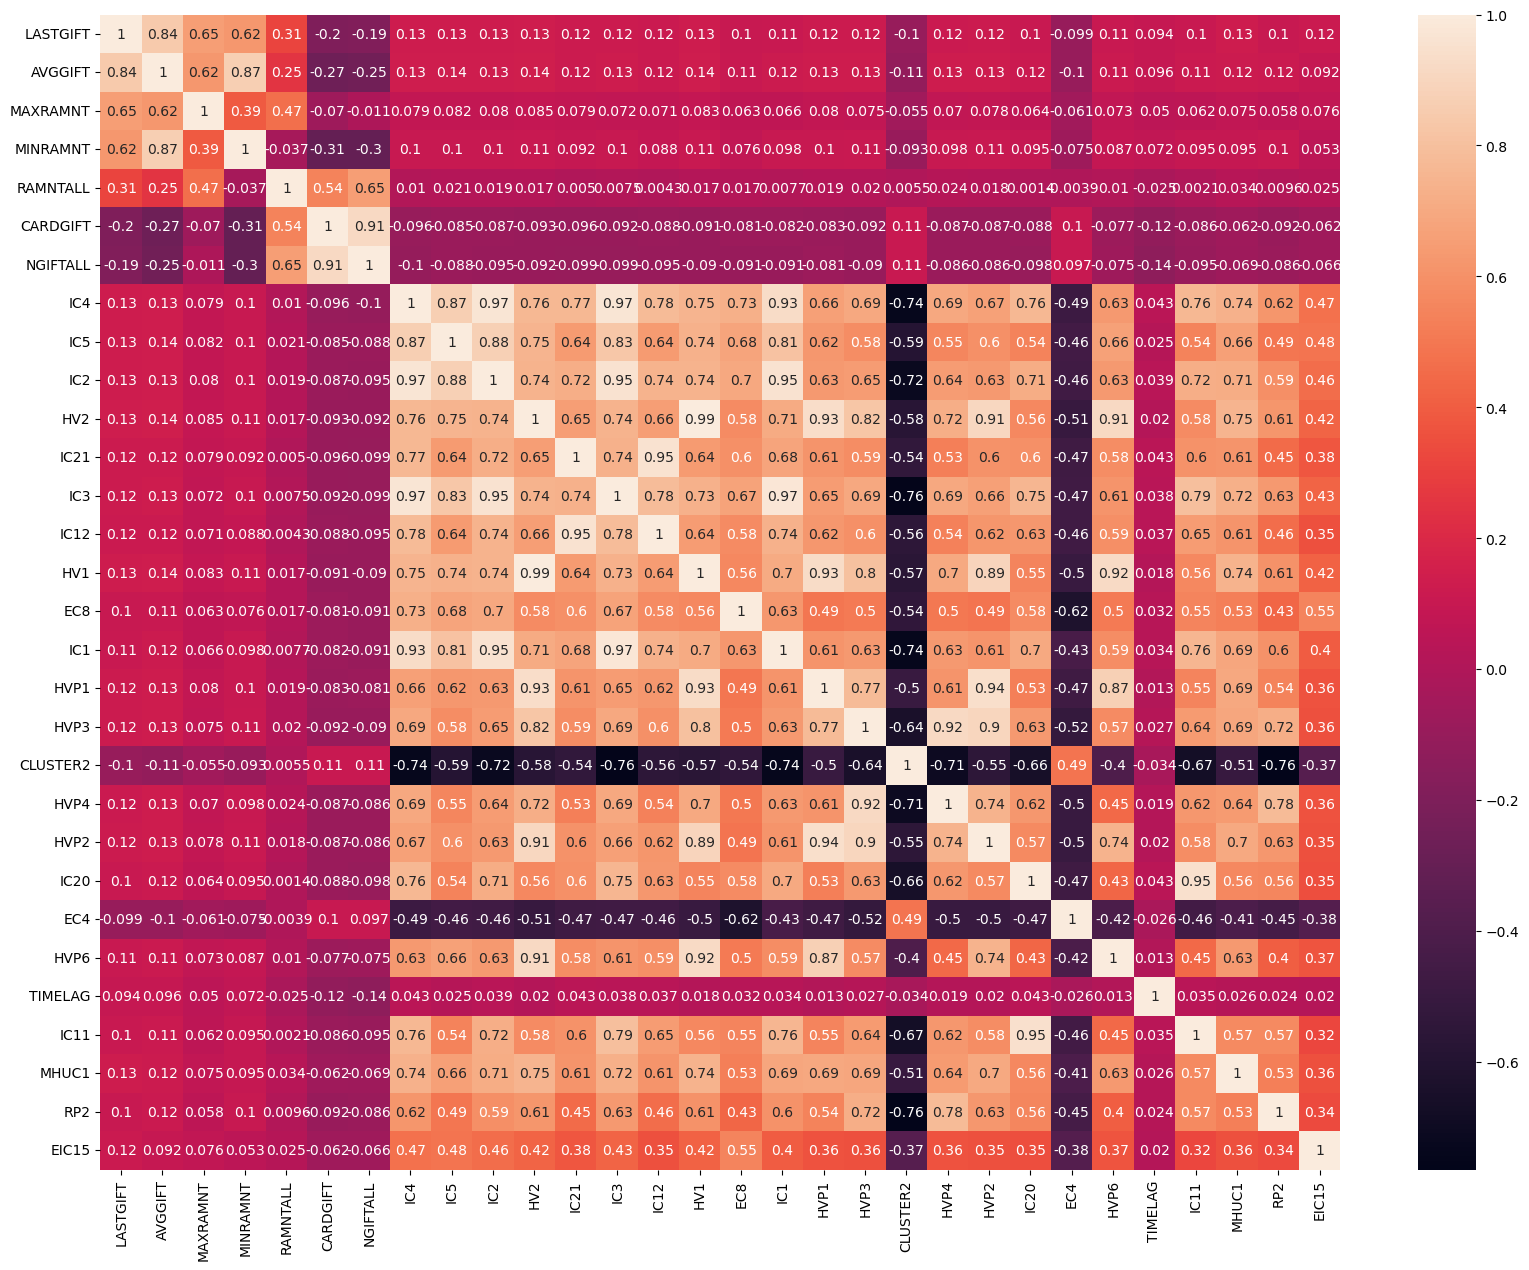

In [39]:
corr_matrix = numerical_Kbest.corr(method='pearson')
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

Dollar amount of gifts: --> only keep AVGGIFT, since relatively high correlation between these variables.  
'LASTGIFT':     Dollar amount of most recent gift  
'AVGGIFT',:     Average dollar amount of gifts to date  
'MAXRAMNT',     Dollar amount of largest gift to date  
'MINRAMNT',     Dollar amount of smallest gift to date  
'RAMNTALL',     Dollar amount of lifetime gifts to date  

'TIMELAG',      Number of months between first and second gift  --> keep  

--> only keep NGIFTALL, since high correlation + CARDGIFT incl. in NGIFTALL
'CARDGIFT',     Number of lifetime gifts to card promotions to date  
'NGIFTALL',     Number of lifetime gifts to date

Income: --> drop because we already have an "income" value in the categoricals.
'IC4',          Average Family Income in hundreds  
'IC5',          Per Capita Income  
'IC2',          Median Family Income in hundreds  
'IC21',         Percent Families w/ Income $100,000 - $124,999  
'IC3',          Average Household Income in hundreds  
'IC12',         Percent Households w/ Income $100,000 - $124,999     
'IC1',          Median Household Income in hundreds  
'IC20',         Percent Families w/ Income $75,000 - $99,999  
'IC11',         Percent Households w/ Income $75,000 - $99,999  

Home Value: --> only keep HV2, since high correlation with other values.
'HV2',          Average Home Value in hundreds  
'HV1',          Median Home Value in hundreds   
'HVP1',         Percent Home Value >= $200,000  
'HVP3',         Percent Home Value >= $100,000  
'HVP4',         Percent Home Value >= $75,000  
'HVP2',         Percent Home Value >= $150,000  
'HVP6',         Percent Home Value >= $300,000  

Education: --> keep Education  
'EC8',          Percent Adults 25+ Graduate Degree  
'EC4',          Percent Adults 25+ Completed High School or Equivalency  

--> keep CLUSTER2  
'CLUSTER2',     Classic Cluster Code (a nominal symbolic field)  

Rent/Mortgage: --> to highly correlated with Home Value and Income  
'MHUC1',        Median Homeowner Cost w/ Mortgage per Month dollars  
'RP2',          Percent Renters Paying >= $400 per Month  

Employment: --> keep
'EIC15'         Percent Employed in Other Professional Services   

In [40]:
getcollinearity(corr_matrix,'EIC15')

EC8      0.549938
EIC15    1.000000
Name: EIC15, dtype: float64

In [41]:
numerical_donors_drop = ['LASTGIFT', 'MAXRAMNT', 'MINRAMNT', 'RAMNTALL','CARDGIFT','IC4',
 'IC5','IC2','IC21', 'IC3','IC12', 'HV1','IC1', 'HVP1', 'HVP3','HVP4', 'HVP2','IC20', 'HVP6',
 'IC11', 'MHUC1', 'RP2',]

numerical_donors_keep = ['AVGGIFT','NGIFTALL','HV2','EC8', 'CLUSTER2', 'EC4','TIMELAG','EIC15']

In [42]:
numerical_donors_selected = numerical_Kbest #numerical_donors.filter(numerical_donors_keep)
display(numerical_donors_selected.shape)
numerical_donors_selected.head()

(4843, 30)

,LASTGIFT,AVGGIFT,MAXRAMNT,MINRAMNT,RAMNTALL,CARDGIFT,NGIFTALL,IC4,IC5,IC2,HV2,IC21,IC3,IC12,HV1,EC8,IC1,HVP1,HVP3,CLUSTER2,HVP4,HVP2,IC20,EC4,HVP6,TIMELAG,IC11,MHUC1,RP2,EIC15
20,5.0,4.066667,7.0,2.0,61.0,10,15,580,20328,501,960,8,540,7,902,7,468,0,35,3,74,4,14,24,0,12,11,9,96,7
30,7.0,6.181818,10.0,2.0,68.0,6,11,663,19703,638,1166,7,652,7,1002,13,633,4,50,14,94,15,19,12,2,9,19,12,83,9
45,5.0,4.857143,6.0,3.0,102.0,14,21,703,26007,637,1399,6,607,5,1282,15,550,15,74,11,88,33,22,21,2,3,17,11,57,8
78,10.0,11.000000,17.0,5.0,132.0,5,12,959,50907,963,5471,11,797,10,5000,21,738,99,99,2,99,99,17,9,95,21,13,8,94,12
93,12.0,9.400000,12.0,5.0,94.0,8,10,463,12546,422,698,1,436,1,685,7,409,0,4,22,32,0,12,38,0,6,10,7,84,4


## Modeling

In [43]:
#try modeling without any feature selection for the numericals --> better results than with the feature selection:
data_donors_selected = data_donors

#with feature selection:
#data_donors_selected = pd.concat([categorical_donors, numerical_donors_selected], axis = 1)

display(data_donors_selected.shape)
data_donors_selected.head()

(4843, 323)

,TCODE,AGE,INCOME,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,RFA_2A,DOMAIN_A,DOMAIN_B,LASTDATE_YR,LASTDATE_MM
20,2,62.000000,3,10,2,25,40,27,11,4,1,9,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,5120.0,107.0,613.0,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12,4.066667,82943,1,3,3,other,12,H,F,D,S,1,96,3
30,0,61.611649,5,0,1,37,58,16,8,1,5,9,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,2920.0,201.0,618.0,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9,6.181818,190313,1,3,14,TX,35,H,M,D,T,1,95,12
45,0,66.000000,5,5,0,33,24,39,6,5,1,9,2160,683,900,89,0,11,48,52,99,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,42,47,49,40,48,50,20,33,42,25,7,14,23,21,17,13,5,14,13,33,22,18,24,7,22,22,43,35,19,6,1,72,7,5,16,165,240,69,58,1,28,27,4,0,0,0,1282,1399,5,4,96,4,97,3,8,27,76,71,25,89,11,2,0,2,9,18,2,16,62,21,0,0,0,15,33,74,88,98,2,0,70,67,67,13,3,28,0,0,2,2,0,0,39,57,71,89,1360.0,173.0,637.0,550,637,607,703,26007,5,11,19,10,24,17,5,3,5,1,5,16,12,28,22,6,5,6,27,1,76,1,61,39,12,89,7,0,0,0,0,0,0,3,1,

### X/y-Split

In [44]:
y = target_donors['TARGET_D']
X = data_donors_selected

### Train/Test-Split

In [45]:
# We do the Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Split both Train and Test in numericals and categoricals

In [46]:
#splitting into categorical and numerical
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)

X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)

In [47]:
display(X_train_num.shape)
X_train_num.head()
#display(X_train_cat.shape)

(3874, 310)

,TCODE,AGE,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,CLUSTER2
24086,0,38.000000,0,5,22,58,0,10,8,9,1735,487,643,14,0,86,50,50,79,7,0,2,24,0,0,0,0,0,1,0,21,1,0,2,28,33,34,28,36,38,29,46,39,15,9,46,25,10,6,3,1,24,16,36,14,10,6,1,4,17,34,48,25,8,4,65,13,2,20,195,269,89,89,0,0,0,0,0,0,0,731,762,5,4,88,12,93,7,2,44,76,64,36,86,14,8,1,7,15,13,7,19,56,4,3,4,0,0,1,7,45,95,0,1,43,51,53,15,5,0,0,11,8,0,0,3,42,54,70,84,640.0,203.0,635.0,375,398,390,414,15419,7,11,26,33,19,4,0,0,0,4,10,23,35,22,5,0,0,0,5,0,37,3,79,21,17,78,20,0,0,0,0,0,0,2,1,6,24,28,5,87,88,89,87,85,84,91,69,95,99,1,15,26,4,4,20,0,2,5,1,14,4,2,3,3,0,6,20,3,3,4,9,5,8,1,0,7,9,9,15,10,8,9,9,59,5,0,140,2,6,17,38,8,21,7,6,24,2,19,8,3,5,2,12,22,1,58,18,0,27,1,3,0,13,0,0,8,8,0,1,0,0,3,1,0,5,54,86,9,3,2,98,73,10,3,4,10,83,86,94,98,2,0,0,71,18,11,0,0,0,92,8,76,99,99,8,3,6,1,6,14,5,12,20.0,1,1,20.0,20.0,20.0,9,20.000000,127320,20
8621,1,50.000000,0,4,41,65,5,7,5,12,1661,448,540,0,0,99,51,49,95,0,1,1,5,0,0,0,0,0,0,0,4,0,0,1,34,43,45,34,45,48,29,35,42,23,11,18,25,19,15,7,5,16,14,32,22,16,19,4,15,13,33,54,35,18,7,67,10,5,18,219,304,71,71,0,0,0,0,0,0,0,1264,1332,5,3,84,16,98,2,9,42,83,74,36,90,10,7,3,4,13,6,4,22,60,13,0,0,0,15,32,61,83,99,1,2,50,54,56,16,5,0,0,28,9,0,0,6,34,49,64,76,6920.0,67.0,862.0,403,427,424,457,12093,12,16,12,30,20,8,1,1,0,9,11,12,36,21,9,1,1,0,25,8,37,4,50,50,11,76,7,2,2,0,0,2,3,11,0,46,33,39,12,79,68,84,53,81,44,51,49,33,99,10,8,7,3,12,18,1,0,4,7,22,8,6,4,9,0,10,14,5,4,2,11,6,9,1,1,6,3,3,17,7,5,12,16,55,4,2,126,6,16,24,37,7,6,4,1,28,1,22,6,2,4,0,20,41,1,65,19,5,8,0,7,1,6,0,0,1,1,1,2,0,0,1,3,0,8,60,91,1,1,7,99,87,41,6,16,8,15,30,69,74,26,0,0,7,26,19,1,0,47,9,89,10,99,97,8,4,9,2,10,24,5,12,50.0,2,1,25.0,25.0,25.0,4,25.000000,171014,41
83419,0,45.000000,1,0,35,34,32,4,5,6,1828,530,579,99,0,0,53,47,92,6,0,2,6,0,0,1,1,0,0,0,4,0,1,2,38,46,47,35,45,48,30,24,33,43,10,11,23,32,18,5,1,9,11,26,33,21,10,1,6,8,36,56,34,12,3,68,4,3,25,227,298,94,93,0,6,6,6,5,5,0,1324,1398,9,6,93,7,93,7,2,44,92,86,41,91,9,3,1,2,6,6,1,18,64,10,1,5,0,5,25,94,99,99,1,6,93,81,78,16,3,0,6,0,4,0,3,0,55,58,61,63,3360.0,201.0,618.0,770,779,825,841,33254,0,1,3,10,33,30,14,3,8,0,1,3,6,34,30,14,3,8,13,2,81,0,44,56,16,93,5,1,1,0,0,0,1,1,2,6,18,26,8,57,62,78,46,78,45,50,42,99,99,0,41,21,2,16,9,0,0,2,3,3,1,1,1,3,2,6,23,1,0,6,10,5,8,3,1,6,10,9,6,4,5,6,7,71,7,0,160,1,3,7,17,7,38,27,4,29,2,22,8,0,0,0,18,35,0,34

### MIN-MAX-Scaling:

In [48]:
# Transformation on numericals:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_train_num)
numericals_train_scaled = transformer.transform(X_train_num)
numericals_train_scaled = pd.DataFrame(numericals_train_scaled, columns=X_train_num.columns)

numericals_test_scaled = transformer.transform(X_test_num)
numericals_test_scaled = pd.DataFrame(numericals_test_scaled, columns=X_test_num.columns)

### Ordinal Encoding:

- Income, 
- Wealth2, 
- Domain_B

In [49]:
# # Ordinal Encoding
ordinal_train = X_train_cat[['INCOME', 'WEALTH2', 'DOMAIN_B']]
ordinal_test = X_test_cat[['INCOME', 'WEALTH2', 'DOMAIN_B']]
display(ordinal_train.shape)
ordinal_train.head()

(3874, 3)

,INCOME,WEALTH2,DOMAIN_B
24086,2,9,1
8621,5,9,2
83419,6,9,1
5643,5,9,3
51263,1,9,1


### ONEHOT Encoding

In [50]:
onehot_train= X_train_cat.drop(['INCOME', 'WEALTH2', 'DOMAIN_B'], axis = 1)
onehot_test= X_test_cat.drop(['INCOME', 'WEALTH2', 'DOMAIN_B'], axis = 1)
display(onehot_train.shape)
onehot_train.head()

(3874, 10)

,HPHONE_D,RFA_2F,STATE,CLUSTER,HOMEOWNR,GENDER,RFA_2A,DOMAIN_A,LASTDATE_YR,LASTDATE_MM
24086,0,1,TX,12,H,F,F,S,96,2
8621,0,1,CA,44,H,M,G,R,95,4
83419,1,2,TX,24,H,M,F,C,96,3
5643,0,1,GA,31,H,M,F,C,96,2
51263,1,2,FL,2,U,F,F,U,96,2


In [51]:
# ONEHOT Encoding:
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(onehot_train)

categoricals_train_encoded = encoder.transform(onehot_train).toarray()
categoricals_test_encoded = encoder.transform(onehot_test).toarray()

In [52]:
# Combine train and test-data
X_train_processed = np.concatenate((ordinal_train, categoricals_train_encoded, numericals_train_scaled),axis=1)
X_test_processed = np.concatenate((ordinal_test, categoricals_test_encoded, numericals_test_scaled),axis=1)

In [53]:
X_train_processed.shape

(3874, 403)

### Model Pipeline to check the best model

In [54]:
model1 = DecisionTreeRegressor()
model2 = LinearRegression()
model3 = KNeighborsRegressor()

model_pipeline = [model1, model2, model3]
model_names = ['Decision Tree Regressor', 'Linear Regression', 'KNN']
scores = {}
for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train_processed, y_train, cv=5))
    scores[model_name] = mean_score
print(scores)

# We can use the result to choose the best performing model

{'Decision Tree Regressor': -0.10905681451345883, 'Linear Regression': 0.19022434992643328, 'KNN': 0.043798804962847736}


The results provided seem to have some issues here, since the "Decision Tree Regressor" has a negative score.

### Modeling

In [55]:
lm = linear_model.LinearRegression()
lm.fit(X_train_processed,y_train)
y_predicted_train = lm.predict(X_train_processed)
R2_train = r2_score(y_train, y_predicted_train)
#print("R2-score (train data) is", R2_train) #
y_predicted_test = lm.predict(X_test_processed)

R2_test = r2_score(y_test, y_predicted_test)
mse=mean_squared_error(y_test,y_predicted_test)
rmse = np.sqrt(mean_squared_error(y_test,y_predicted_test))
mae = mean_absolute_error(y_test, y_predicted_test)

In [56]:
print("R2-score (train data) is ", R2_train)        #seems quite bad
print("R2-score (test data) is ", R2_test)          #seems quite bad
print("mean squared error (MSE) is ", mse)          #seems high but it is ^2
print("root mean squared error (RMSE) is ", rmse)   #error of 9.37$ predictions
print("mean absolute error (MAE) is ", mae)         #error of 4.75$ predictions seems ok

R2-score (train data) is  0.5525602643287916
R2-score (test data) is  0.5607768478694973
mean squared error (MSE) is  65.3215617521967
root mean squared error (RMSE) is  8.08217555811532
mean absolute error (MAE) is  5.082519652186533


## Predictions

1. We need to import the information about which rows were predicted to be donors from our classifier from Lab 7_05
2. predict for the predicted donors from 7_05 with the model from 7_06 the donation amount
3. Total revenue = sum(predicted $$$ for predicted 1's) - len(predicted 1's)*0.68.

In [57]:
final_data_target_b_pred = pd.read_csv('final_data_y_pred.csv')

In [58]:
final_data_target_b_pred.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,STATE_other,HOMEOWNR_U,GENDER_M,GENDER_other,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U,TARGET_B,TARGET_B_Predicted
0,0.555556,0.0,0.656566,0.070707,0.131313,0.272727,0.020202,0.050505,0.171717,0.0,0.313131,0.545455,0.909091,0.404040,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1
1,1.000000,1.0,0.000000,0.989899,0.989899,0.989899,0.919192,0.919192,0.919192,1.0,0.979798,1.000000,0.969697,1.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
2,0.111111,0.0,0.989899,0.010101,0.060606,0.181818,0.000000,0.020202,0.090909,1.0,0.505051,0.696970,0.000000,0.171717,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1
3,0.000000,0.0,0.929293,0.252525,0.505051,0.696970,0.010101,0.080808,0.171717,1.0,0.393939,0.454545,0.454545,0.222222,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1
4,1.000000,1.0,0.000000,0.010101,0.020202,0.161616,0.252525,0.585859,0.747475,1.0,0.060606,0.333333,0.090909,0.212121,1.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0


In [59]:
#concatenate the data
data_predictions = pd.concat([numerical, categorical, final_data_target_b_pred['TARGET_B_Predicted']], axis = 1)

In [60]:
# From past labs and lessons we know that some.
# column looks more categorical than numerical.
data_predictions['INCOME'] = data_predictions['INCOME'].astype('object')
data_predictions['WEALTH1'] = data_predictions['WEALTH1'].astype('object')
data_predictions['WEALTH2'] = data_predictions['WEALTH2'].astype('object')
data_predictions['HPHONE_D'] = data_predictions['HPHONE_D'].astype('object')
data_predictions['RFA_2F'] = data_predictions['RFA_2F'].astype('object')

#Change categorical columns to object CLUSTER,DOMAIN_B, LASTDATE_YR, LASTDATE_MM:
data_predictions['CLUSTER'] = data_predictions['CLUSTER'].astype('object')
data_predictions['DOMAIN_B'] = data_predictions['DOMAIN_B'].astype('object')
data_predictions['LASTDATE_YR'] = data_predictions['LASTDATE_YR'].astype('object')
data_predictions['LASTDATE_MM'] = data_predictions['LASTDATE_MM'].astype('object')

In [61]:
data_predictions.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B_Predicted
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,1
1,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10,0
2,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3,3,0,49

### Predicted Donor-Split

In [62]:
data_pred_donation = data_predictions[data_predictions['TARGET_B_Predicted']==1]

In [63]:
display(data_pred_donation.shape)
data_pred_donation.head()

(38379, 338)

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B_Predicted
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,1
2,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3,3,0,497,546,2,1,78,22,93,7,18,36,76,65,30,86,14,7,2,5,11,17,3,17,60,18,0,1,0,0,1,6,18,50,0,4,36,49,51,14,5,4,2,24,11,2,3,6,0,2,9,44,0.0,281.0,518.0,251,292,292,340,11576,32,18,20,15,12,2,0,0,1,20,19,24,18,16,2,0,0,1,28,8,31,11,38,62,8,74,22,0,0,0,0,0,2,2,1,21,19,24,6,61,65,73,59,70,56,78,62,82,99,4,10,5,2,6,12,0,1,9,5,18,20,5,7,6,0,11,33,4,3,2,12,3,3,2,0,7,8,3,3,6,7,1,8,74,3,1,120,22,20,28,16,6,5,3,1,23,1,16,6,0,0,0,10,21,0,28,23,32,8,1,14,1,5,0,0,7,0,0,0,0,0,1,0,0,2,84,96,3,0,0,92,65,29,9,22,3,12,23,50,69,31,0,0,0,6,35,44,0,15,22,77,17,97,92,9,2,6,5,26,63,6,14,202.0,27,14,2.0,16.0,5.0,12,7.481481,15078,1,4,60,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1,1
3,0,70.000000,1,4,2,0,23,14,31,3,0,3,0,640,160,219,0,8,92,54,46,61,0,0,11,32,6,2,0,0,0,0,0,31,0,0,1,32,40,44,34,43,47,25,45,35,20,15,25,17,17,12,7,7,20,17,30,14,19,25,11,23,23,27,50,30,15,8,63,9,6,23,199,283,85,83,3,4,1,0,2,0,2,1000,1263,2,1

In [64]:
# Feature Selection from above:
data_pred_donation = data_pred_donation.drop(columns=categorical_to_drop)

In [65]:
# Drop the TARGET_B column
data_pred_donation = data_pred_donation.drop(columns='TARGET_B_Predicted')

In [66]:
data_pred_donation.shape

(38379, 323)

### Data scaling and encoding

In [67]:
#splitting into categorical and numerical
data_pred_donation_num = data_pred_donation.select_dtypes(include = np.number)
data_pred_donation_cat = data_pred_donation.select_dtypes(include = object)

In [68]:
# Transformation on numericals:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(data_pred_donation_num)
data_pred_donation_num_scaled = transformer.transform(data_pred_donation_num)
data_pred_donation_num_scaled = pd.DataFrame(data_pred_donation_num_scaled, columns=X_train_num.columns)

In [69]:
# # Ordinal Encoding
ordinal_data_pred_donation_cat = data_pred_donation_cat[['INCOME', 'WEALTH2', 'DOMAIN_B']]
display(ordinal_data_pred_donation_cat.shape)
ordinal_data_pred_donation_cat.head()

(38379, 3)

,INCOME,WEALTH2,DOMAIN_B
0,5,5,2
2,3,1,2
3,1,0,2
6,4,3,2
7,2,9,2


In [70]:
onehot_data_pred_donation_cat= data_pred_donation_cat.drop(['INCOME', 'WEALTH2', 'DOMAIN_B'], axis = 1)
display(onehot_data_pred_donation_cat.shape)
onehot_data_pred_donation_cat.head()

(38379, 10)

,HPHONE_D,RFA_2F,STATE,CLUSTER,HOMEOWNR,GENDER,RFA_2A,DOMAIN_A,LASTDATE_YR,LASTDATE_MM
0,0,4,IL,36,H,F,E,T,95,12
2,1,4,NC,43,U,M,E,R,95,12
3,1,4,CA,44,U,F,E,R,95,12
6,1,1,IN,40,H,F,E,T,95,4
7,1,3,other,39,U,F,E,T,95,8


In [71]:
# ONEHOT Encoding:
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(onehot_data_pred_donation_cat)

data_pred_donation_cat_encoded = encoder.transform(onehot_data_pred_donation_cat).toarray()

In [72]:
# Combine train and test-data
data_pred_donation_processed = np.concatenate((ordinal_data_pred_donation_cat, data_pred_donation_cat_encoded, data_pred_donation_num_scaled),axis=1)

### Predictions of the donation amount of the predicted donors

In [73]:
predicted_donation = lm.predict(data_pred_donation_processed)

### Total Revenue

In [78]:
total_revenue = sum(predicted_donation) - len(data_predictions[data_predictions['TARGET_B_Predicted']==1]['TARGET_B_Predicted'])*0.68
total_revenue

945351.5068066407

## Conclusion

We predict a total revenue of 945'352$.
The model pipeline concluded, that the linear regression was the best model to use here. (Although it seems that there are some issues, since the KNN and the DecisionTree Regressor end up with very bad results..)
The linear regression was first done with a kbest and manual feature selection but the r2-score was worse than with no feature selection of the numerical columns at all.